In [1]:
import multiprocessing
import multiprocessing as mp

def get_num_cores():
    return multiprocessing.cpu_count()

if __name__ == '__main__':
    num_cores = get_num_cores()
    print("Number of CPU cores available:", num_cores)

from tqdm import tqdm
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import pickle
import time
import warnings
import multiprocessing as mp
import numpy as np
import statsmodels.formula.api as smf
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm

import scipy.io
from scipy.io import loadmat
from scipy.interpolate import interp1d

import multiprocessing as mp
import statsmodels.api as sm
import statsmodels.stats.multitest as smm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.stats.multitest import multipletests

Number of CPU cores available: 16


In [ ]:
#for the huge (>10 gb) MATLAB v7.3 file
with h5py.File('/home/ubuntu/data/full_only_after_stimulus_stimlock_unfold_opticat.mat', 'r') as file:
    data = file['data'][:]

data = np.array(data)
data = data[:, :, :]  
n_channels, n_timepoints, n_trials = data.shape
print(data.shape)  

#i want to have electrodes x timepoints x trials:
data = np.transpose(data, (2, 1, 0))
print(data.shape)  

Downsampling! : (4x, 500 Hz -> 125 Hz)

In [ ]:
original_timepoints = np.arange(400)  
new_timepoints = np.linspace(0, 399, 100)  # New timepoints, evenly spaced

data_downsampled = np.empty((data.shape[0], 100, data.shape[2]))

# Interpolating for each elec and each tr
for i in range(data.shape[0]):  # over electrodes
    for j in range(data.shape[2]):  #trials
        f = interp1d(original_timepoints, data[i, :, j], kind='linear') #check with Nicolas
        data_downsampled[i, :, j] = f(new_timepoints)

print(data_downsampled.shape)

In [ ]:
data = data_downsampled

We dont need to run the code above, just load the downsampled data:...

In [2]:
path = '/home/ubuntu/data/downsampled_stimlocked.pkl'

In [ ]:
def save_downsampled(data, filename='downsampled_stimlocked.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

save_downsampled(data, filename=path)

In [3]:
def load_downsampled(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

data = load_downsampled(path)
print(data.shape)  

(105, 100, 35475)


In [4]:
#for running on a smaller subset:
data = data[:,0:50,:] #for the downsampled version these 50 timepoints are corresponding to the 400 ms (200 timepoints) after the stimulus
data.shape

(105, 50, 35475)

... and the second , corresponding tab structure:


In [5]:
# second structure - tab with corresponding info
tab = pd.read_csv('/home/ubuntu/data/tab_199.csv')
tab = tab.drop('Dir', axis=1)
# Categorical conversion
tab['ID'] = tab['ID'].astype('category')
tab['Age'] = tab['Age'].astype('category')
tab['Condition'] = tab['Condition'].astype('category')
print(tab.shape)  
print(tab.head())

(35475, 3)
  Condition   ID Age
0       pro  AA0   1
1       pro  AA0   1
2       pro  AA0   1
3       pro  AA0   1
4       pro  AA0   1


scaling, optional

In [6]:
# data.shape = (105, 50, 35475) electrodes, timepoint, 35475
# Calculate the mean and standard deviation along the trials axis (axis=2)
mean = np.mean(data, axis=2, keepdims=True)
std = np.std(data, axis=2, keepdims=True)
data = (data - mean) / std
print(data.shape)

(105, 50, 35475)


In [7]:
tab['ID'] = tab['ID'].astype('category')
tab['Age'] = tab['Age'].astype('category')
tab['Condition'] = tab['Condition'].astype('category')
n_channels, n_timepoints, n_trials = data.shape

In [8]:
def fit_model(channel, timepoint, data, tab):
    start_time = time.time()
    print(f"Starting model for channel {channel}, timepoint {timepoint}")
    eeg_data = data[channel, timepoint, :]
    current_tab = tab.copy()
    current_tab['EEG'] = eeg_data
    formula = 'EEG ~ 1 + Condition * Age'
    current_tab['ID'] = current_tab['ID'].cat.codes
    model = smf.mixedlm(formula, current_tab, groups=current_tab['ID'])
    try:
        result = model.fit()
        elapsed_time = time.time() - start_time
        print(f"Finished model for channel {channel}, timepoint {timepoint} in {elapsed_time:.2f} seconds")
        return (channel, timepoint, result, elapsed_time)
    except np.linalg.LinAlgError:
        elapsed_time = time.time() - start_time
        print(f"Model failed to converge for channel {channel}, timepoint {timepoint}")
        return (channel, timepoint, "Model failed to converge", elapsed_time)

if __name__ == '__main__':
    #warnings.filterwarnings("ignore")
    results = {}
    n_channels = 105
    n_timepoints = 50

    num_cores = mp.cpu_count()
    print(f"Number of available cores: {num_cores}")
    pool = mp.Pool(processes=16) 
    jobs = []

    for channel in range(n_channels):
        for timepoint in range(n_timepoints):
            print(f"Submitting job for channel {channel}, timepoint {timepoint}")
            job = pool.apply_async(fit_model, args=(channel, timepoint, data, tab))
            jobs.append(job)

    pool.close()
    pool.join()

    total_elapsed_time = 0
    for job in jobs:
        channel, timepoint, result, elapsed_time = job.get()
        results[(channel, timepoint)] = result
        total_elapsed_time += elapsed_time

    print(f"Total time taken for all models: {total_elapsed_time} seconds")


Number of available cores: 32
Submitting job for channel 0, timepoint 0
Submitting job for channel 0, timepoint 1
Submitting job for channel 0, timepoint 2
Submitting job for channel 0, timepoint 3
Submitting job for channel 0, timepoint 4
Submitting job for channel 0, timepoint 5
Submitting job for channel 0, timepoint 6
Submitting job for channel 0, timepoint 7
Submitting job for channel 0, timepoint 8
Submitting job for channel 0, timepoint 9
Submitting job for channel 0, timepoint 10
Submitting job for channel 0, timepoint 11
Submitting job for channel 0, timepoint 12
Submitting job for channel 0, timepoint 13
Submitting job for channel 0, timepoint 14
Submitting job for channel 0, timepoint 15
Submitting job for channel 0, timepoint 16
Submitting job for channel 0, timepoint 17
Submitting job for channel 0, timepoint 18
Submitting job for channel 0, timepoint 19
Submitting job for channel 0, timepoint 20
Submitting job for channel 0, timepoint 21
Submitting job for channel 0, time

In [9]:
def save_results(results, filename='model_results_50t_downsampled_scaled.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
        
path = '/home/ubuntu/data/model_results_50t_downsampled_scaled.pkl'
save_results(results, filename=path)

---
---
---

## with the pre-calculated results we can start here!

In [10]:
def load_results(filename='model_results_50t_downsampled_scaled.pkl.pkl'):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [11]:
filename = '/home/ubuntu/data/model_results_50t_downsampled_scaled.pkl'
results = load_results(filename)

In [12]:
print(results[(6, 8)].summary())  # Example  model's summary

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    EEG        
No. Observations:      35475      Method:                REML       
No. Groups:            199        Scale:                 0.9906     
Min. group size:       33         Log-Likelihood:        -50275.9190
Max. group size:       238        Converged:             Yes        
Mean group size:       178.3                                        
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 -0.001    0.013 -0.048 0.962 -0.027  0.025
Condition[T.pro]           0.022    0.014  1.580 0.114 -0.005  0.049
Age[T.1]                  -0.025    0.021 -1.193 0.233 -0.065  0.016
Condition[T.pro]:Age[T.1]  0.003    0.022  0.128 0.898 -0.039  0.045
Group Var                  0.009    0.001         

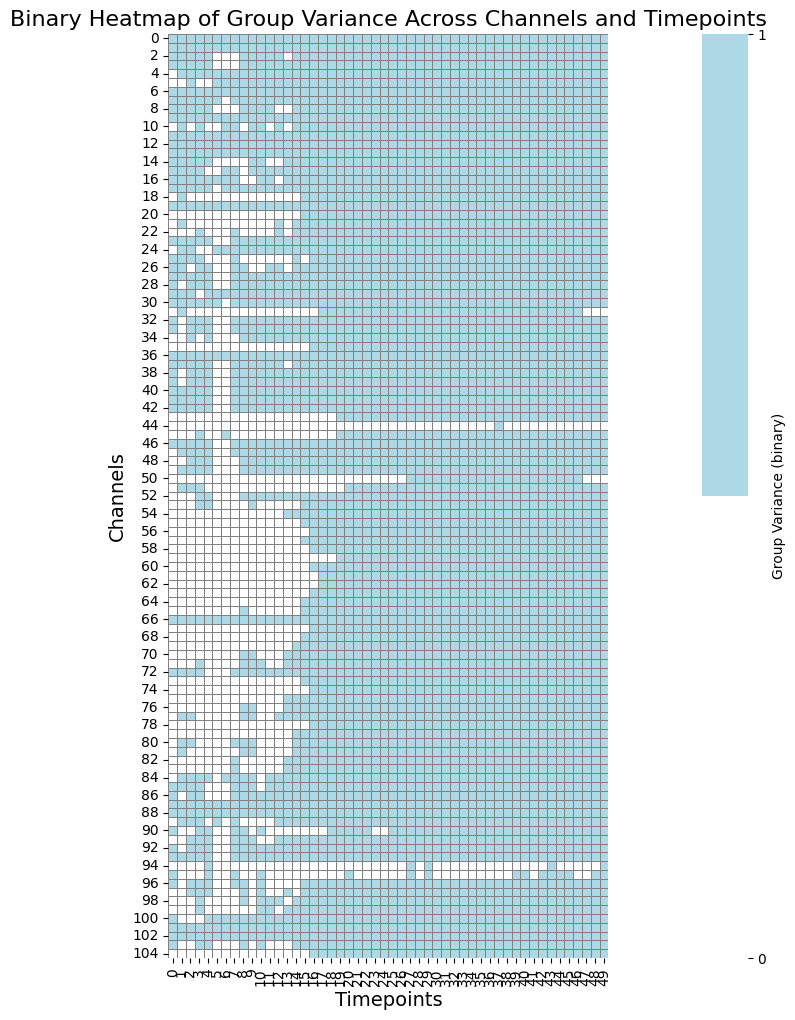

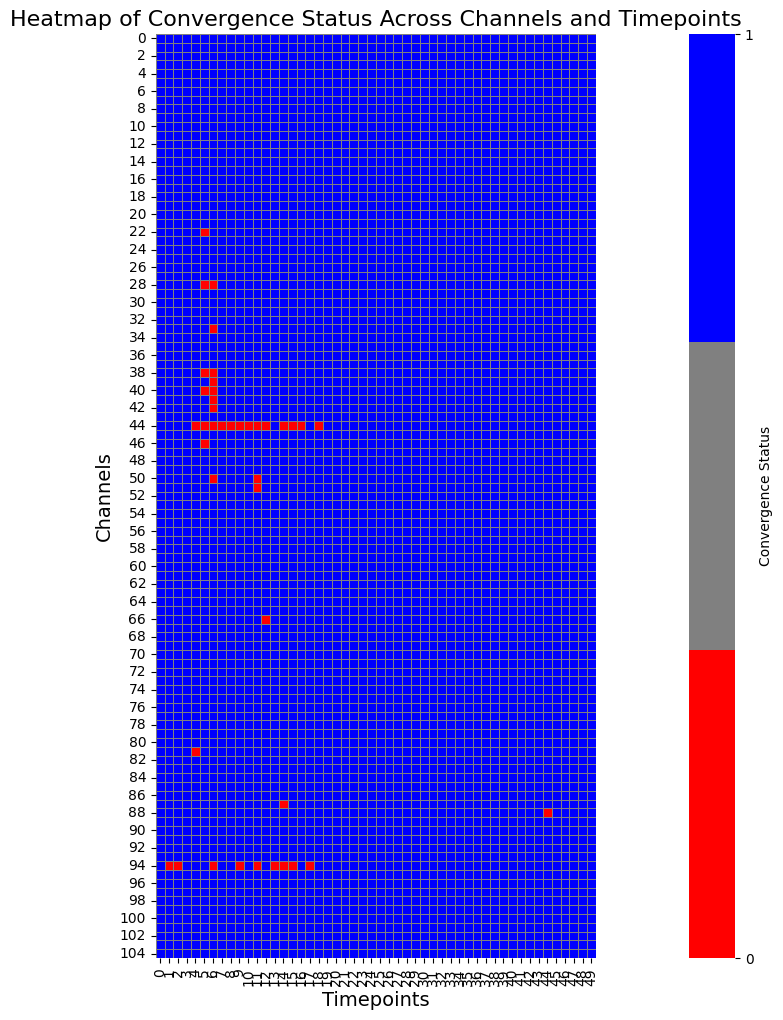

In [13]:
def extract_group_var(results):
    group_vars = {}
    for key, result in results.items():
        try:
            summary_str = result.summary().as_text()
            for line in summary_str.split('\n'):
                if 'Group Var' in line:
                    group_var_value = float(line.split()[2])  
                    group_vars[key] = group_var_value
                    break
        except Exception as e:
            print(f"Failed to extract for {key}: {str(e)}")
    return group_vars

def plot_group_vars(group_vars, n_channels, n_timepoints):
    group_var_matrix = np.zeros((n_channels, n_timepoints))

    for (channel, timepoint), group_var in group_vars.items():
        group_var_matrix[channel, timepoint] = group_var

    # Create a binary matrix where values >0 are set to 1
    binary_matrix = np.where(group_var_matrix > 0, 1, 0)

    # Create a custom colormap: white for 0 and pastel blue for 1
    cmap = ListedColormap(['white', 'lightblue'])

    # Plot the heatmap
    plt.figure(figsize=(24, 12))
    ax = sns.heatmap(binary_matrix, cmap=cmap, cbar=True, square=True, 
                cbar_kws={'label': 'Group Variance (binary)', 'ticks': [0, 1]}, linewidths=.5, linecolor='gray')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['0', '1'])
    
    plt.xlabel('Timepoints', fontsize=14)
    plt.ylabel('Channels', fontsize=14)
    plt.title('Binary Heatmap of Group Variance Across Channels and Timepoints', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

def extract_convergence(results):
    convergence_status = {}
    for key, result in results.items():
        try:
            convergence_status[key] = 'Yes' if result.converged else 'No'
        except AttributeError:
            convergence_status[key] = 'Unknown'
        except Exception as e:
            print(f"Failed to extract for {key}: {str(e)}")
    return convergence_status

def plot_convergence(convergence_status, n_channels, n_timepoints):
    convergence_matrix = np.full((n_channels, n_timepoints), 'Unknown', dtype=object)

    for (channel, timepoint), status in convergence_status.items():
        convergence_matrix[channel, timepoint] = status

    status_to_num = {'Yes': 1, 'No': 0, 'Unknown': -1}
    convergence_matrix_num = np.vectorize(status_to_num.get)(convergence_matrix)

    colors = ["red", "gray", "blue"]
    cmap = ListedColormap(colors)

    plt.figure(figsize=(24, 12))
    sns.heatmap(convergence_matrix_num, cmap=cmap, cbar=True, square=True, 
                cbar_kws={'ticks': [0, 1], 'label': 'Convergence Status'},
                linewidths=.5, linecolor='gray')
    plt.xlabel('Timepoints', fontsize=14)
    plt.ylabel('Channels', fontsize=14)
    plt.title('Heatmap of Convergence Status Across Channels and Timepoints', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

n_channels = 105
n_timepoints = 50

group_vars = extract_group_var(results)
convergence_status = extract_convergence(results)
plot_group_vars(group_vars, n_channels, n_timepoints)
plot_convergence(convergence_status, n_channels, n_timepoints)

STATISTICS:

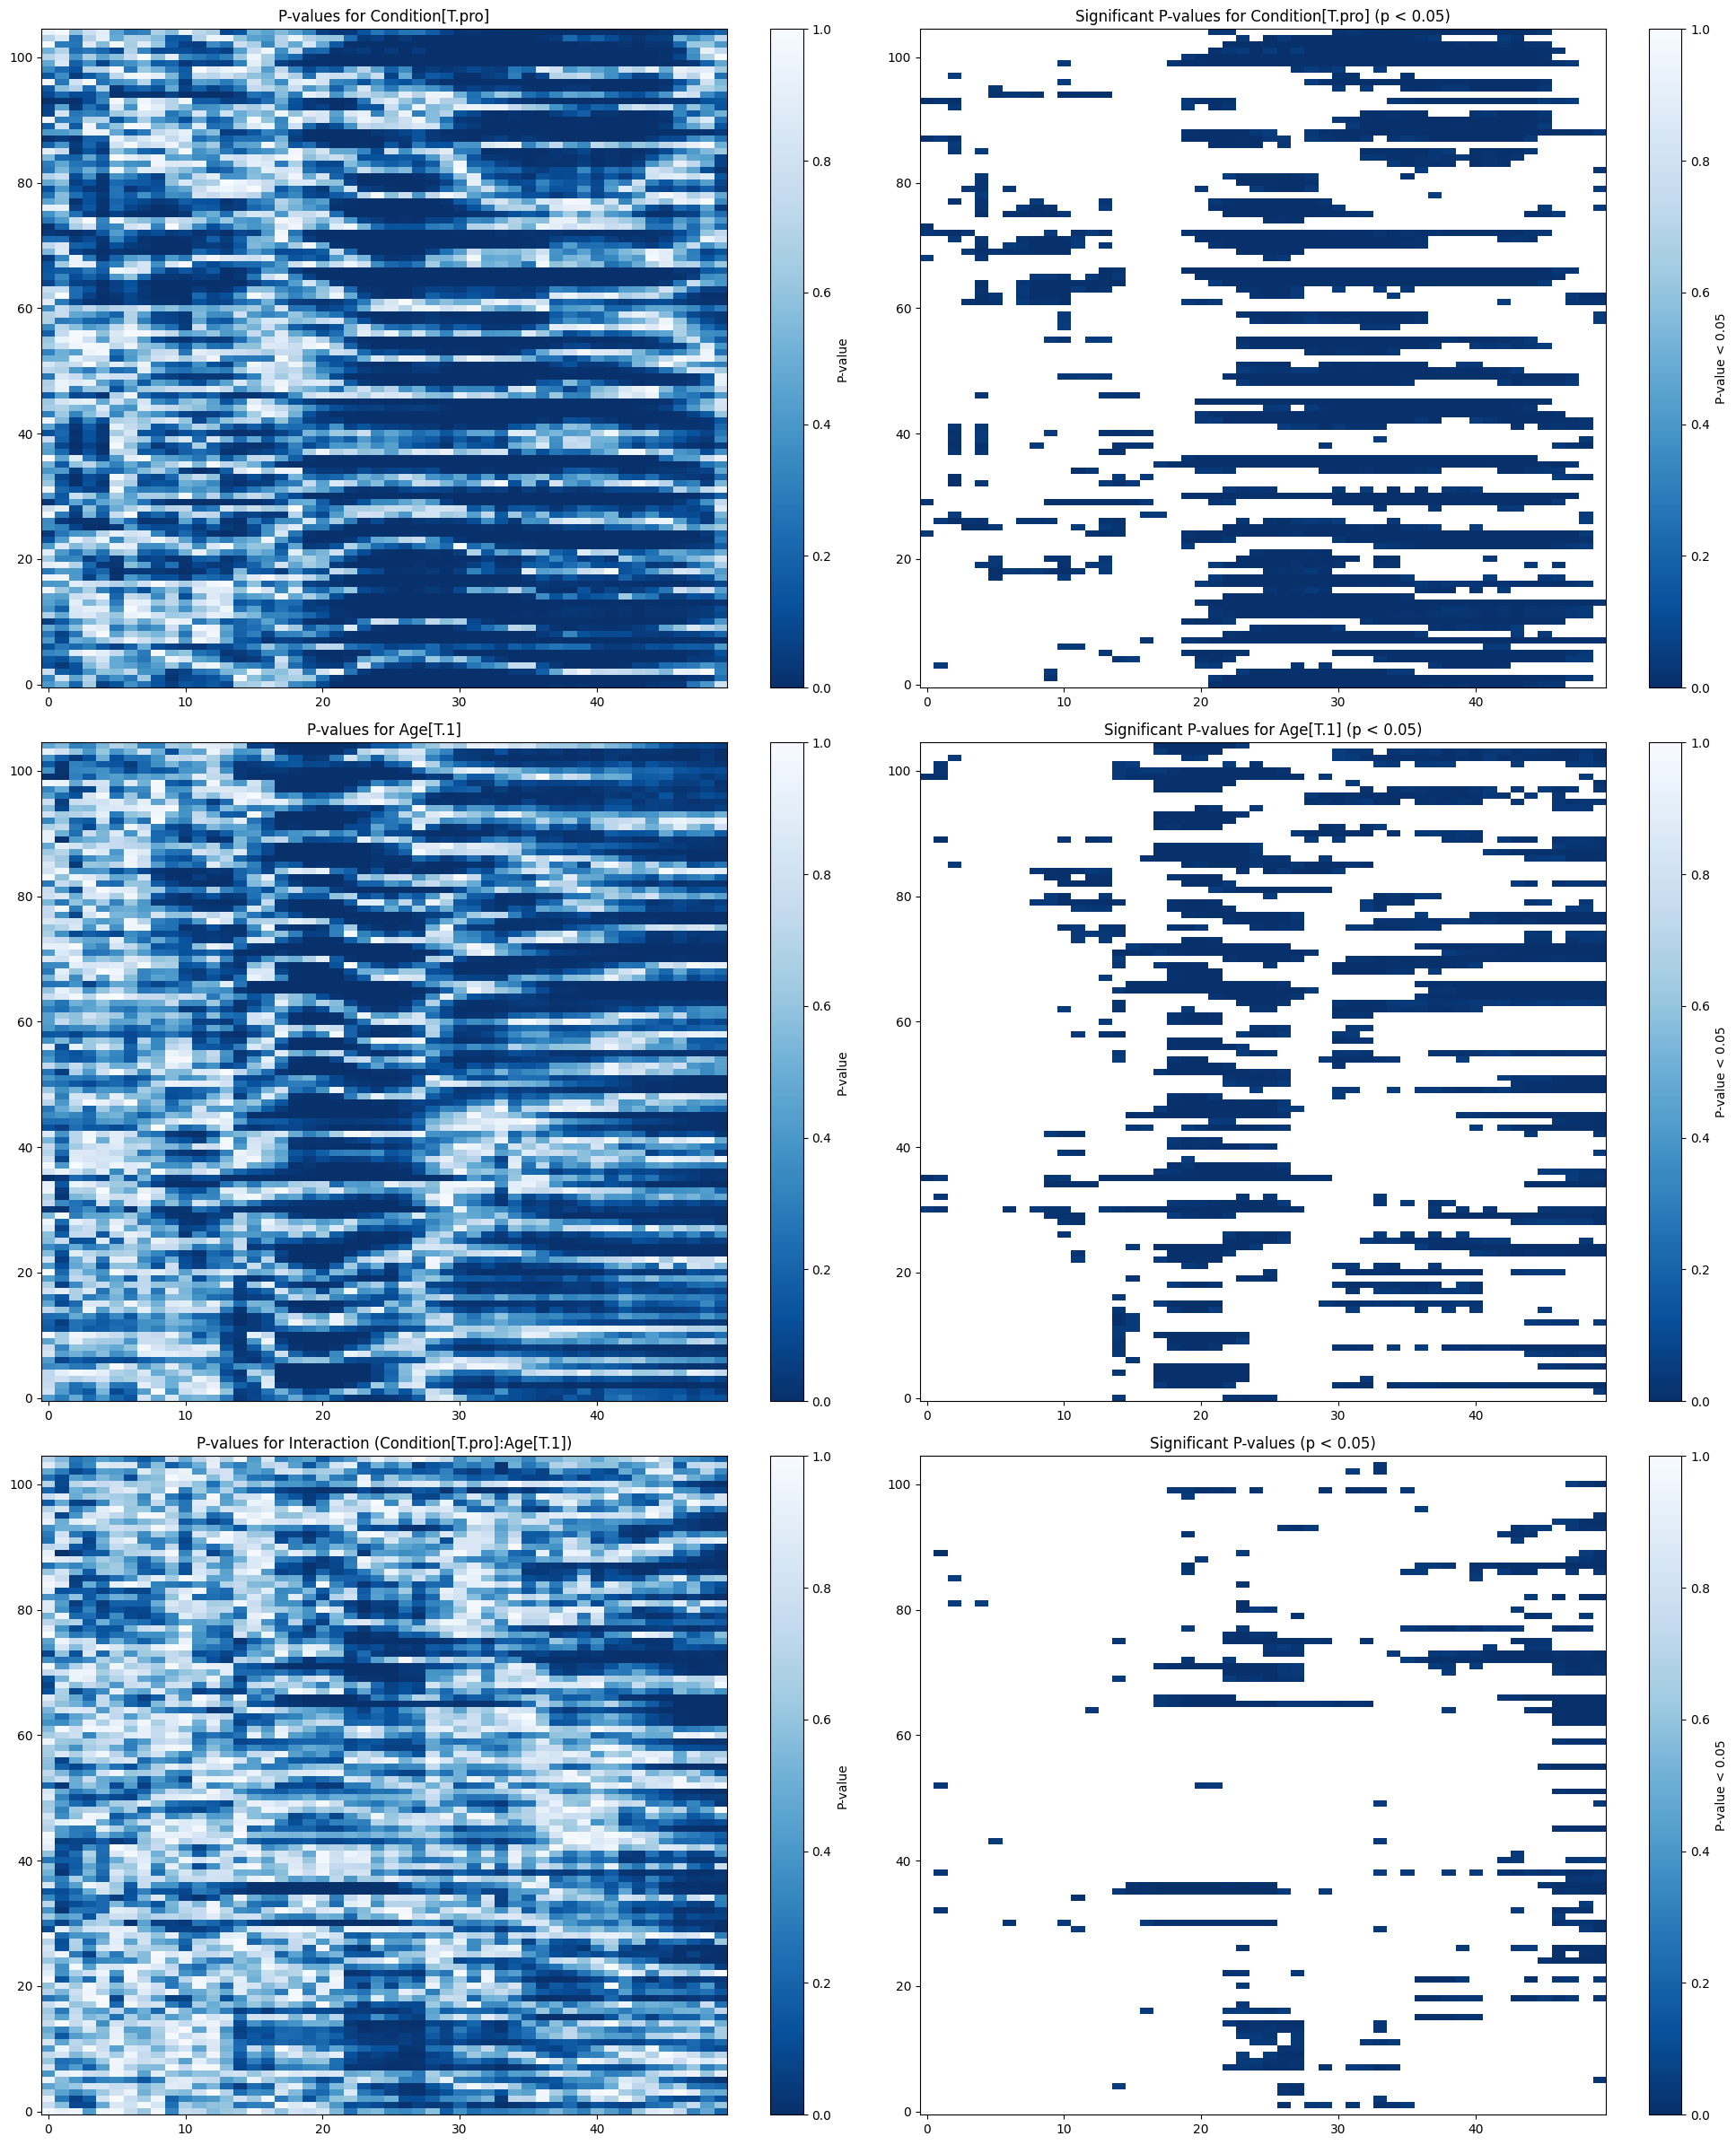

In [15]:
def plot_complex_pvalues(results):
    plt.figure(figsize=(20, 24))  #  3 rows and 2 columns of plots

    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    # Condition[T.pro]
    ax1 = plt.subplot(3, 2, 1)
    cax1 = ax1.imshow(pvalues_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax1, ax=ax1, label='P-value')
    ax1.set_title('P-values for Condition[T.pro]')

    ax2 = plt.subplot(3, 2, 2)
    significant_cond = np.where(pvalues_cond < 0.05, pvalues_cond, np.nan)
    cax2 = ax2.imshow(significant_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax2, ax=ax2, label='P-value < 0.05')
    ax2.set_title('Significant P-values for Condition[T.pro] (p < 0.05)')

    # Age[T.1]
    ax3 = plt.subplot(3, 2, 3)
    cax3 = ax3.imshow(pvalues_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax3, ax=ax3, label='P-value')
    ax3.set_title('P-values for Age[T.1]')

    ax4 = plt.subplot(3, 2, 4)
    significant_age = np.where(pvalues_age < 0.05, pvalues_age, np.nan)
    cax4 = ax4.imshow(significant_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax4, ax=ax4, label='P-value < 0.05')
    ax4.set_title('Significant P-values for Age[T.1] (p < 0.05)')

    # Interaction
    ax5 = plt.subplot(3, 2, 5)
    cax5 = ax5.imshow(pvalues_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax5, ax=ax5, label='P-value')
    ax5.set_title('P-values for Interaction (Condition[T.pro]:Age[T.1])')

    ax6 = plt.subplot(3, 2, 6)
    significant_interaction = np.where(pvalues_interaction < 0.05, pvalues_interaction, np.nan)
    cax6 = ax6.imshow(significant_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax6, ax=ax6, label='P-value < 0.05')
    ax6.set_title('Significant P-values (p < 0.05)')

    plt.tight_layout()  
    plt.show()

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues

def load_results(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)


plot_complex_pvalues(results)

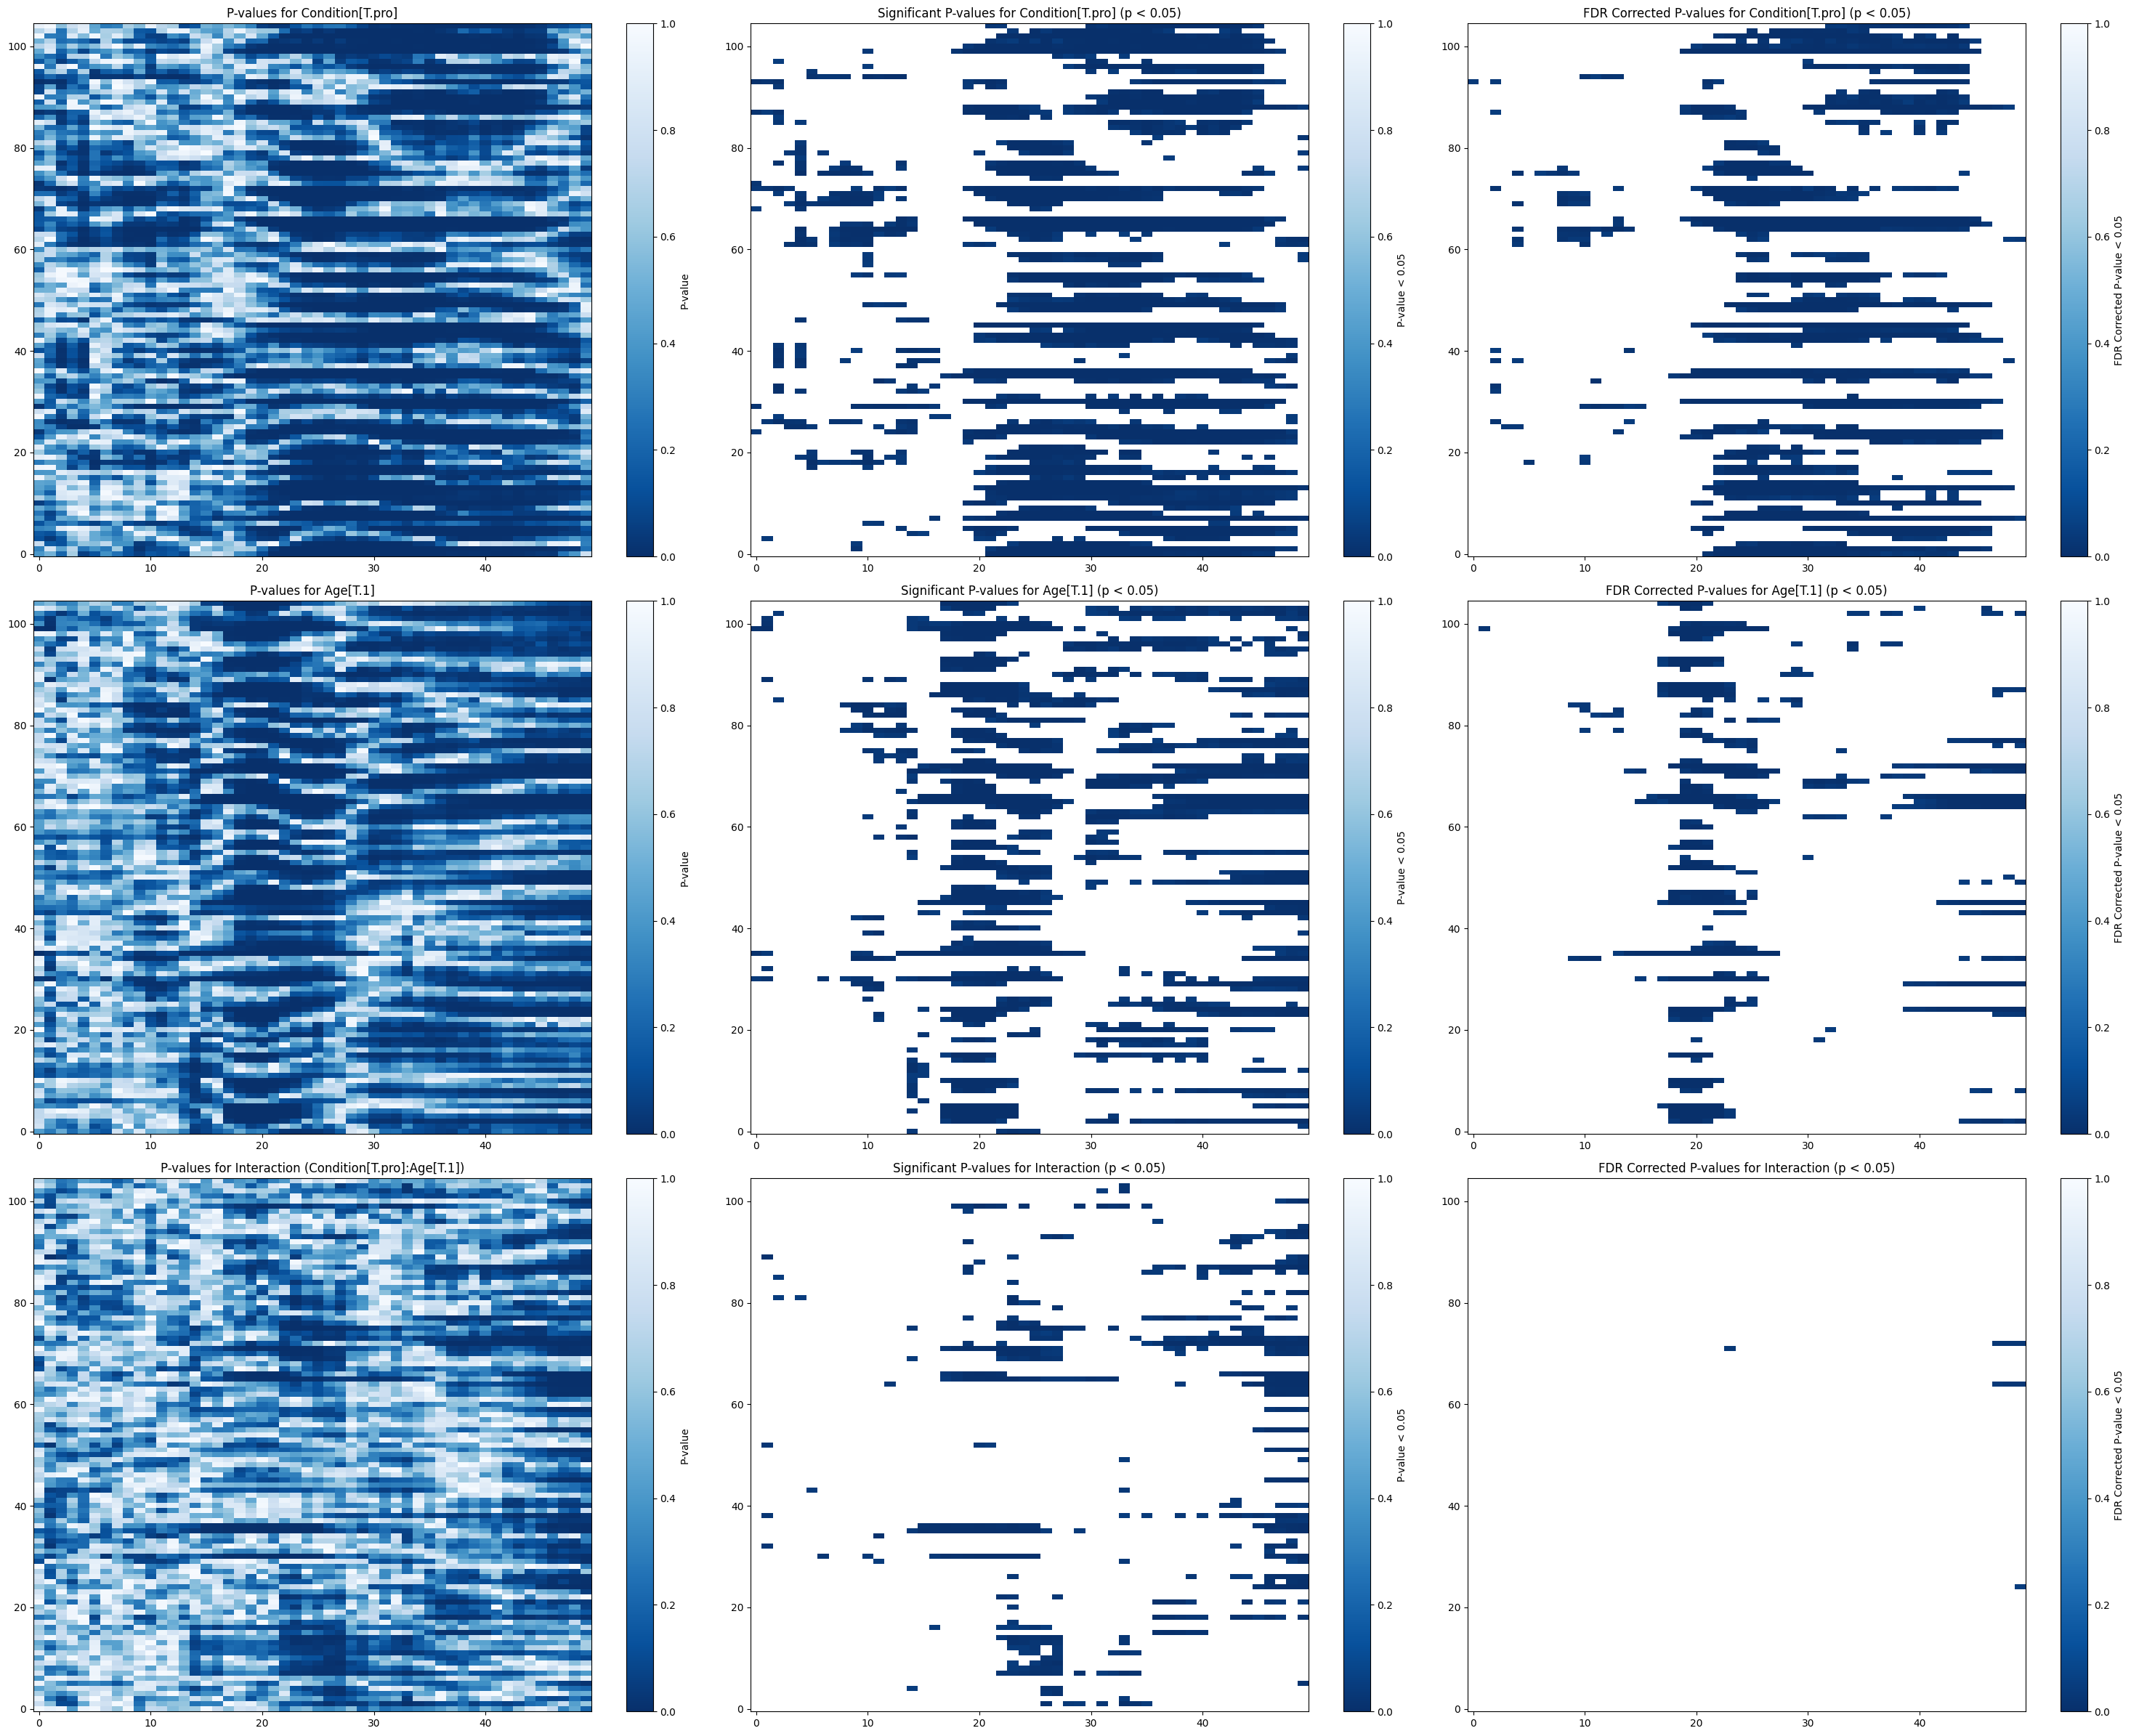

In [16]:

from statsmodels.stats.multitest import multipletests

def plot_complex_pvalues(results):
    plt.figure(figsize=(30, 24))  # 3 rows and 3 columns of plots

    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    fdr_corrected_cond = fdr_correction(pvalues_cond)
    fdr_corrected_age = fdr_correction(pvalues_age)
    fdr_corrected_interaction = fdr_correction(pvalues_interaction)

    # Condition[T.pro]
    ax1 = plt.subplot(3, 3, 1)
    cax1 = ax1.imshow(pvalues_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax1, ax=ax1, label='P-value')
    ax1.set_title('P-values for Condition[T.pro]')

    ax2 = plt.subplot(3, 3, 2)
    significant_cond = np.where(pvalues_cond < 0.05, pvalues_cond, np.nan)
    cax2 = ax2.imshow(significant_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax2, ax=ax2, label='P-value < 0.05')
    ax2.set_title('Significant P-values for Condition[T.pro] (p < 0.05)')

    ax3 = plt.subplot(3, 3, 3)
    significant_fdr_cond = np.where(fdr_corrected_cond < 0.05, fdr_corrected_cond, np.nan)
    cax3 = ax3.imshow(significant_fdr_cond, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax3, ax=ax3, label='FDR Corrected P-value < 0.05')
    ax3.set_title('FDR Corrected P-values for Condition[T.pro] (p < 0.05)')

    # Age[T.1]
    ax4 = plt.subplot(3, 3, 4)
    cax4 = ax4.imshow(pvalues_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax4, ax=ax4, label='P-value')
    ax4.set_title('P-values for Age[T.1]')

    ax5 = plt.subplot(3, 3, 5)
    significant_age = np.where(pvalues_age < 0.05, pvalues_age, np.nan)
    cax5 = ax5.imshow(significant_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax5, ax=ax5, label='P-value < 0.05')
    ax5.set_title('Significant P-values for Age[T.1] (p < 0.05)')

    ax6 = plt.subplot(3, 3, 6)
    significant_fdr_age = np.where(fdr_corrected_age < 0.05, fdr_corrected_age, np.nan)
    cax6 = ax6.imshow(significant_fdr_age, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax6, ax=ax6, label='FDR Corrected P-value < 0.05')
    ax6.set_title('FDR Corrected P-values for Age[T.1] (p < 0.05)')

    # Interaction
    ax7 = plt.subplot(3, 3, 7)
    cax7 = ax7.imshow(pvalues_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax7, ax=ax7, label='P-value')
    ax7.set_title('P-values for Interaction (Condition[T.pro]:Age[T.1])')

    ax8 = plt.subplot(3, 3, 8)
    significant_interaction = np.where(pvalues_interaction < 0.05, pvalues_interaction, np.nan)
    cax8 = ax8.imshow(significant_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax8, ax=ax8, label='P-value < 0.05')
    ax8.set_title('Significant P-values for Interaction (p < 0.05)')

    ax9 = plt.subplot(3, 3, 9)
    significant_fdr_interaction = np.where(fdr_corrected_interaction < 0.05, fdr_corrected_interaction, np.nan)
    cax9 = ax9.imshow(significant_fdr_interaction, aspect='auto', interpolation='none', origin='lower', cmap='Blues_r', vmin=0, vmax=1)
    plt.colorbar(cax9, ax=ax9, label='FDR Corrected P-value < 0.05')
    ax9.set_title('FDR Corrected P-values for Interaction (p < 0.05)')

    plt.tight_layout()  
    plt.show()

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues

def fdr_correction(pvalues):
    pvalues_flat = pvalues.flatten()
    nan_mask = np.isnan(pvalues_flat)
    pvalues_nonan = pvalues_flat[~nan_mask]

    if pvalues_nonan.size == 0:
        return pvalues

    _, pvalues_corrected, _, _ = multipletests(pvalues_nonan, method='fdr_bh')
    pvalues_corrected_full = np.full_like(pvalues_flat, np.nan)
    pvalues_corrected_full[~nan_mask] = pvalues_corrected

    return pvalues_corrected_full.reshape(pvalues.shape)

def load_results(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)

plot_complex_pvalues(results)


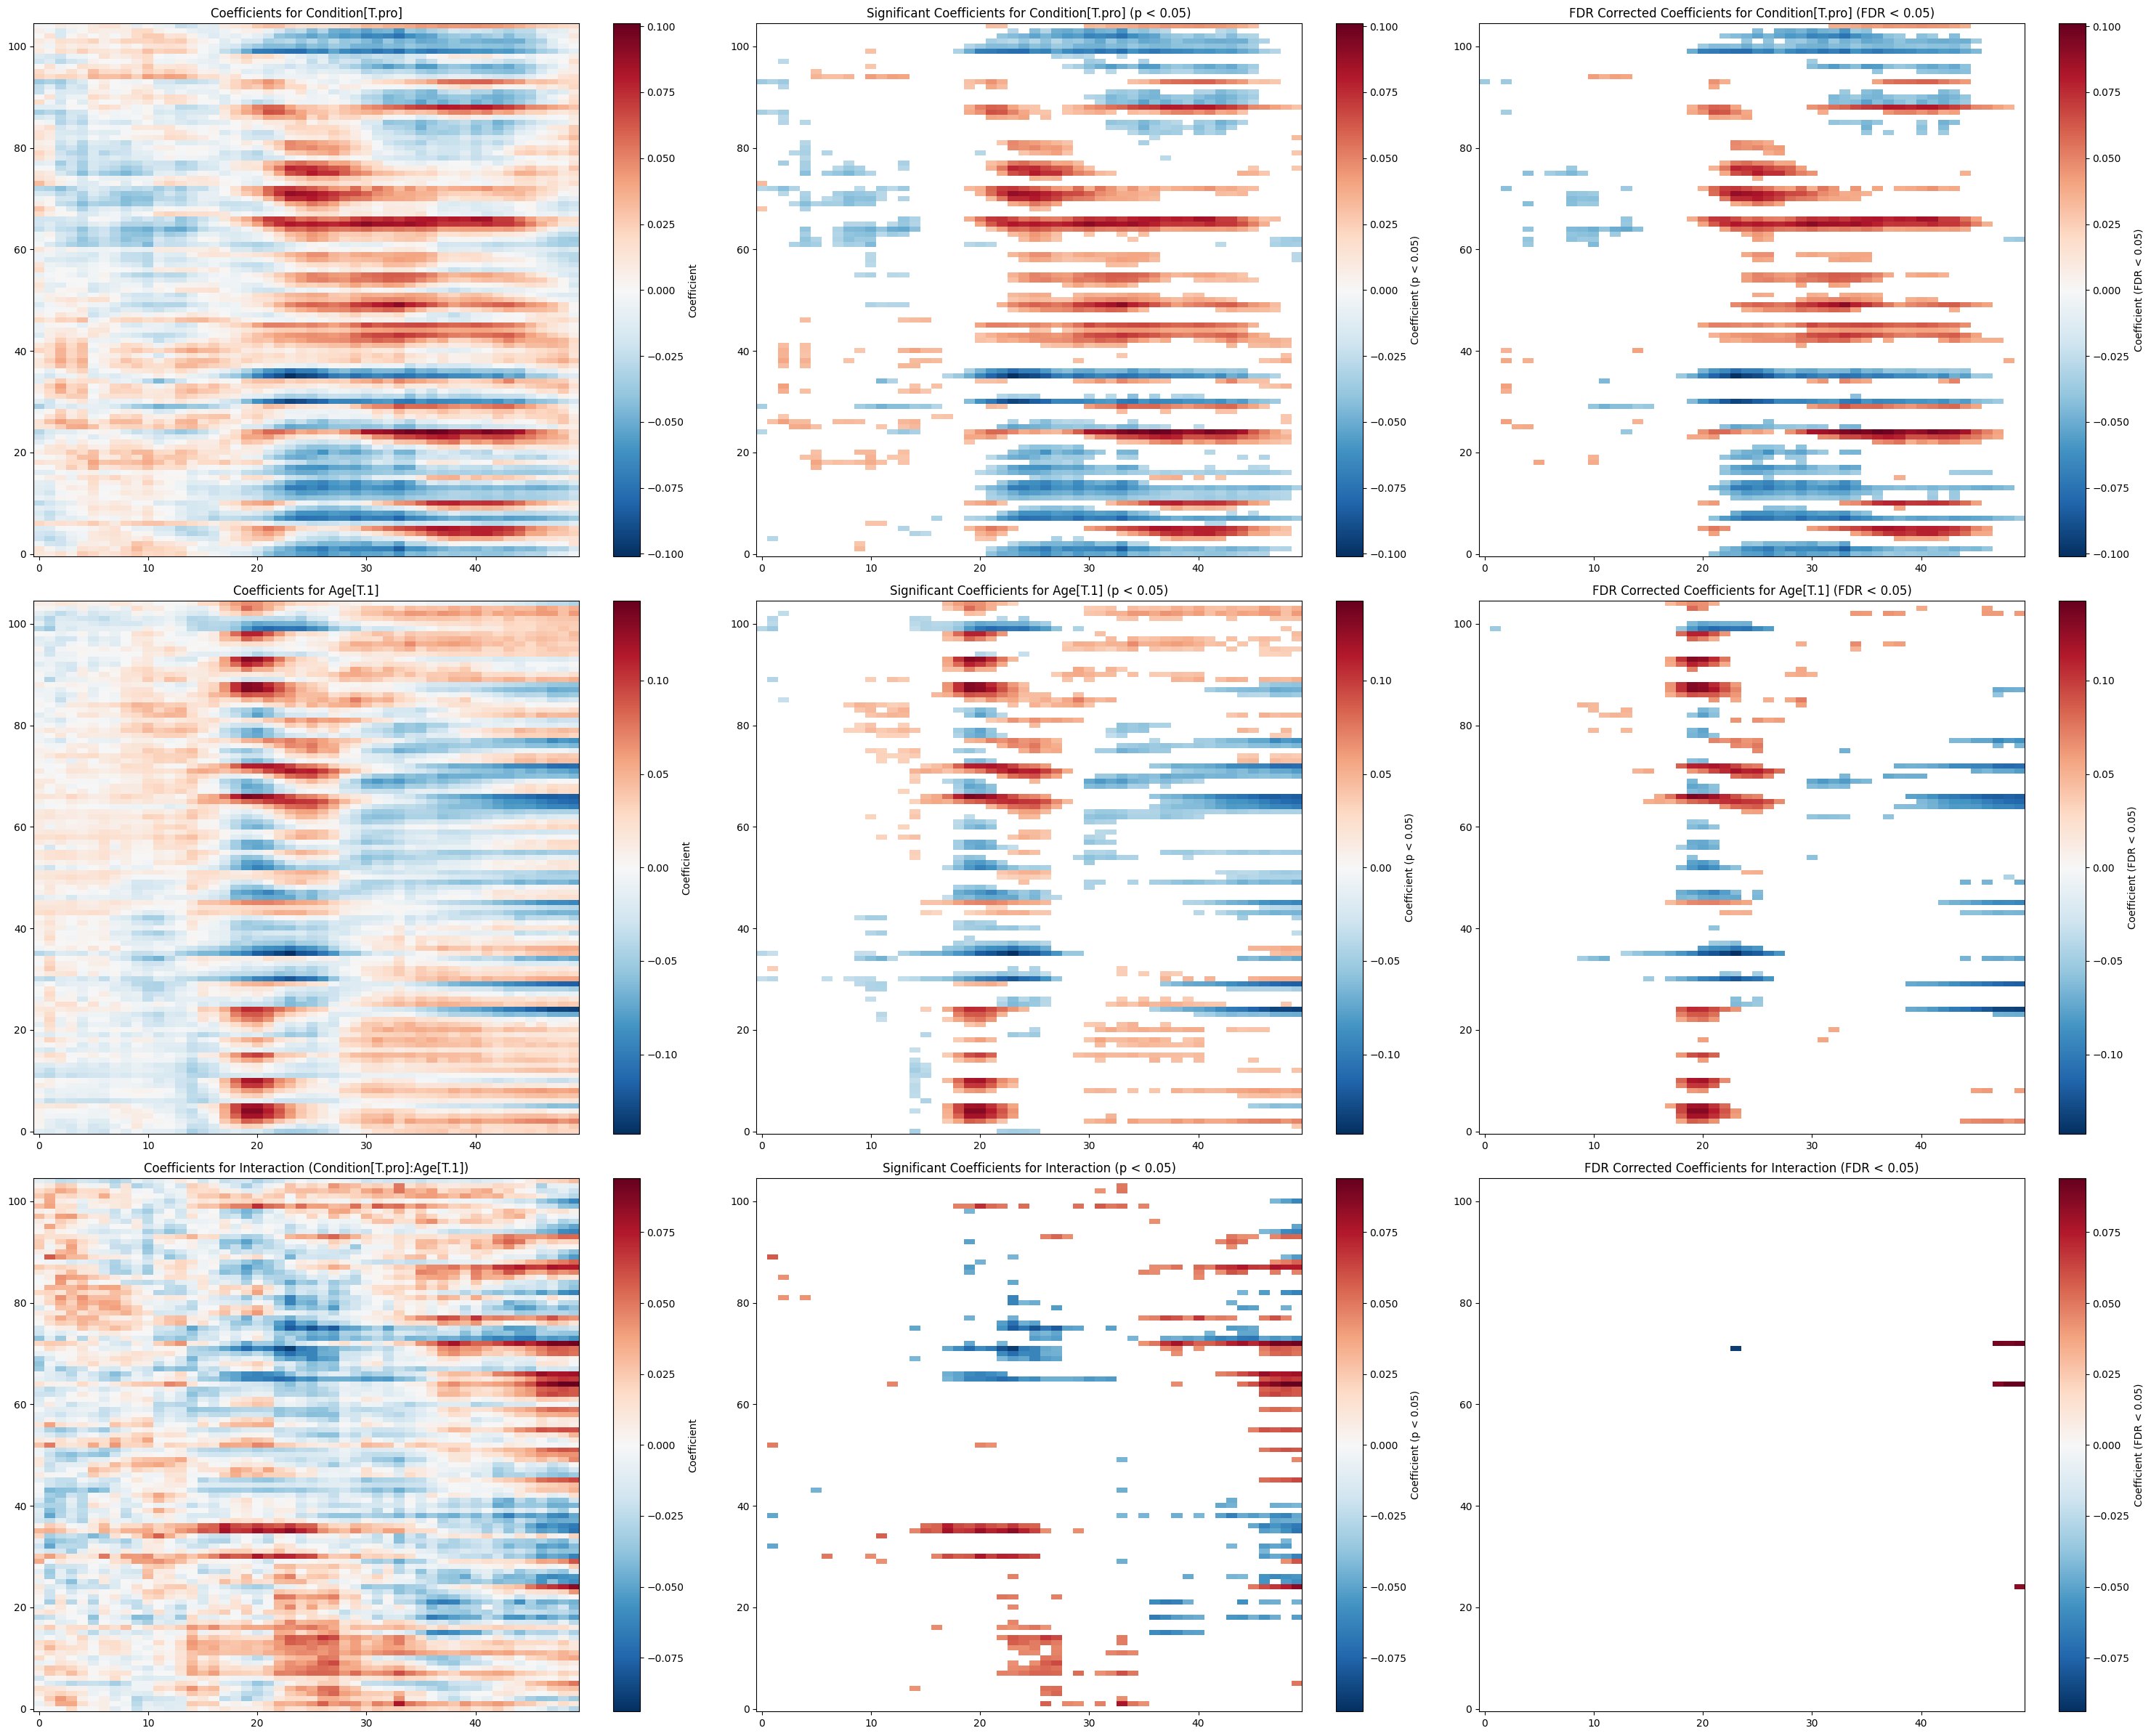

In [17]:

from statsmodels.stats.multitest import multipletests

def plot_complex_coefficients(results):
    plt.figure(figsize=(30, 24))  # 3 rows and 3 columns of plots

    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    fdr_corrected_cond = fdr_correction(pvalues_cond)
    fdr_corrected_age = fdr_correction(pvalues_age)
    fdr_corrected_interaction = fdr_correction(pvalues_interaction)

    coefficients_cond = extract_coefficients(results, 'Condition[T.pro]')
    coefficients_age = extract_coefficients(results, 'Age[T.1]')
    coefficients_interaction = extract_coefficients(results, 'Condition[T.pro]:Age[T.1]')

    # Condition[T.pro]
    ax1 = plt.subplot(3, 3, 1)
    cax1 = ax1.imshow(coefficients_cond, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(coefficients_cond)), vmax=np.nanmax(np.abs(coefficients_cond)))
    plt.colorbar(cax1, ax=ax1, label='Coefficient')
    ax1.set_title('Coefficients for Condition[T.pro]')

    ax2 = plt.subplot(3, 3, 2)
    significant_cond = np.where(pvalues_cond < 0.05, coefficients_cond, np.nan)
    cax2 = ax2.imshow(significant_cond, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_cond)), vmax=np.nanmax(np.abs(significant_cond)))
    plt.colorbar(cax2, ax=ax2, label='Coefficient (p < 0.05)')
    ax2.set_title('Significant Coefficients for Condition[T.pro] (p < 0.05)')


    ax3 = plt.subplot(3, 3, 3)
    significant_fdr_cond = np.where(fdr_corrected_cond < 0.05, coefficients_cond, np.nan)
    cax3 = ax3.imshow(significant_fdr_cond, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_fdr_cond)), vmax=np.nanmax(np.abs(significant_fdr_cond)))
    plt.colorbar(cax3, ax=ax3, label='Coefficient (FDR < 0.05)')
    ax3.set_title('FDR Corrected Coefficients for Condition[T.pro] (FDR < 0.05)')

    # Age[T.1]
    ax4 = plt.subplot(3, 3, 4)
    cax4 = ax4.imshow(coefficients_age, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(coefficients_age)), vmax=np.nanmax(np.abs(coefficients_age)))
    plt.colorbar(cax4, ax=ax4, label='Coefficient')
    ax4.set_title('Coefficients for Age[T.1]')

    ax5 = plt.subplot(3, 3, 5)
    significant_age = np.where(pvalues_age < 0.05, coefficients_age, np.nan)
    cax5 = ax5.imshow(significant_age, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_age)), vmax=np.nanmax(np.abs(significant_age)))
    plt.colorbar(cax5, ax=ax5, label='Coefficient (p < 0.05)')
    ax5.set_title('Significant Coefficients for Age[T.1] (p < 0.05)')

    ax6 = plt.subplot(3, 3, 6)
    significant_fdr_age = np.where(fdr_corrected_age < 0.05, coefficients_age, np.nan)
    cax6 = ax6.imshow(significant_fdr_age, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_fdr_age)), vmax=np.nanmax(np.abs(significant_fdr_age)))
    plt.colorbar(cax6, ax=ax6, label='Coefficient (FDR < 0.05)')
    ax6.set_title('FDR Corrected Coefficients for Age[T.1] (FDR < 0.05)')

    # Interaction
    ax7 = plt.subplot(3, 3, 7)
    cax7 = ax7.imshow(coefficients_interaction, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(coefficients_interaction)), vmax=np.nanmax(np.abs(coefficients_interaction)))
    plt.colorbar(cax7, ax=ax7, label='Coefficient')
    ax7.set_title('Coefficients for Interaction (Condition[T.pro]:Age[T.1])')

    ax8 = plt.subplot(3, 3, 8)
    significant_interaction = np.where(pvalues_interaction < 0.05, coefficients_interaction, np.nan)
    cax8 = ax8.imshow(significant_interaction, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_interaction)), vmax=np.nanmax(np.abs(significant_interaction)))
    plt.colorbar(cax8, ax=ax8, label='Coefficient (p < 0.05)')
    ax8.set_title('Significant Coefficients for Interaction (p < 0.05)')

    ax9 = plt.subplot(3, 3, 9)
    significant_fdr_interaction = np.where(fdr_corrected_interaction < 0.05, coefficients_interaction, np.nan)
    cax9 = ax9.imshow(significant_fdr_interaction, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_fdr_interaction)), vmax=np.nanmax(np.abs(significant_fdr_interaction)))
    plt.colorbar(cax9, ax=ax9, label='Coefficient (FDR < 0.05)')
    ax9.set_title('FDR Corrected Coefficients for Interaction (FDR < 0.05)')

    plt.tight_layout()  
    plt.show()

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues

def extract_coefficients(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    coefficients = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            coefficient = result.params[term]
            coefficients[channel, timepoint] = coefficient
        except (KeyError, AttributeError):
            print(f"Missing coefficient for {term} (Channel {channel}, Timepoint {timepoint})")

    return coefficients

def fdr_correction(pvalues):
    pvalues_flat = pvalues.flatten()
    nan_mask = np.isnan(pvalues_flat)
    pvalues_nonan = pvalues_flat[~nan_mask]

    if pvalues_nonan.size == 0:
        return pvalues

    _, pvalues_corrected, _, _ = multipletests(pvalues_nonan, method='fdr_bh')
    pvalues_corrected_full = np.full_like(pvalues_flat, np.nan)
    pvalues_corrected_full[~nan_mask] = pvalues_corrected

    return pvalues_corrected_full.reshape(pvalues.shape)

def load_results(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)

plot_complex_coefficients(results)


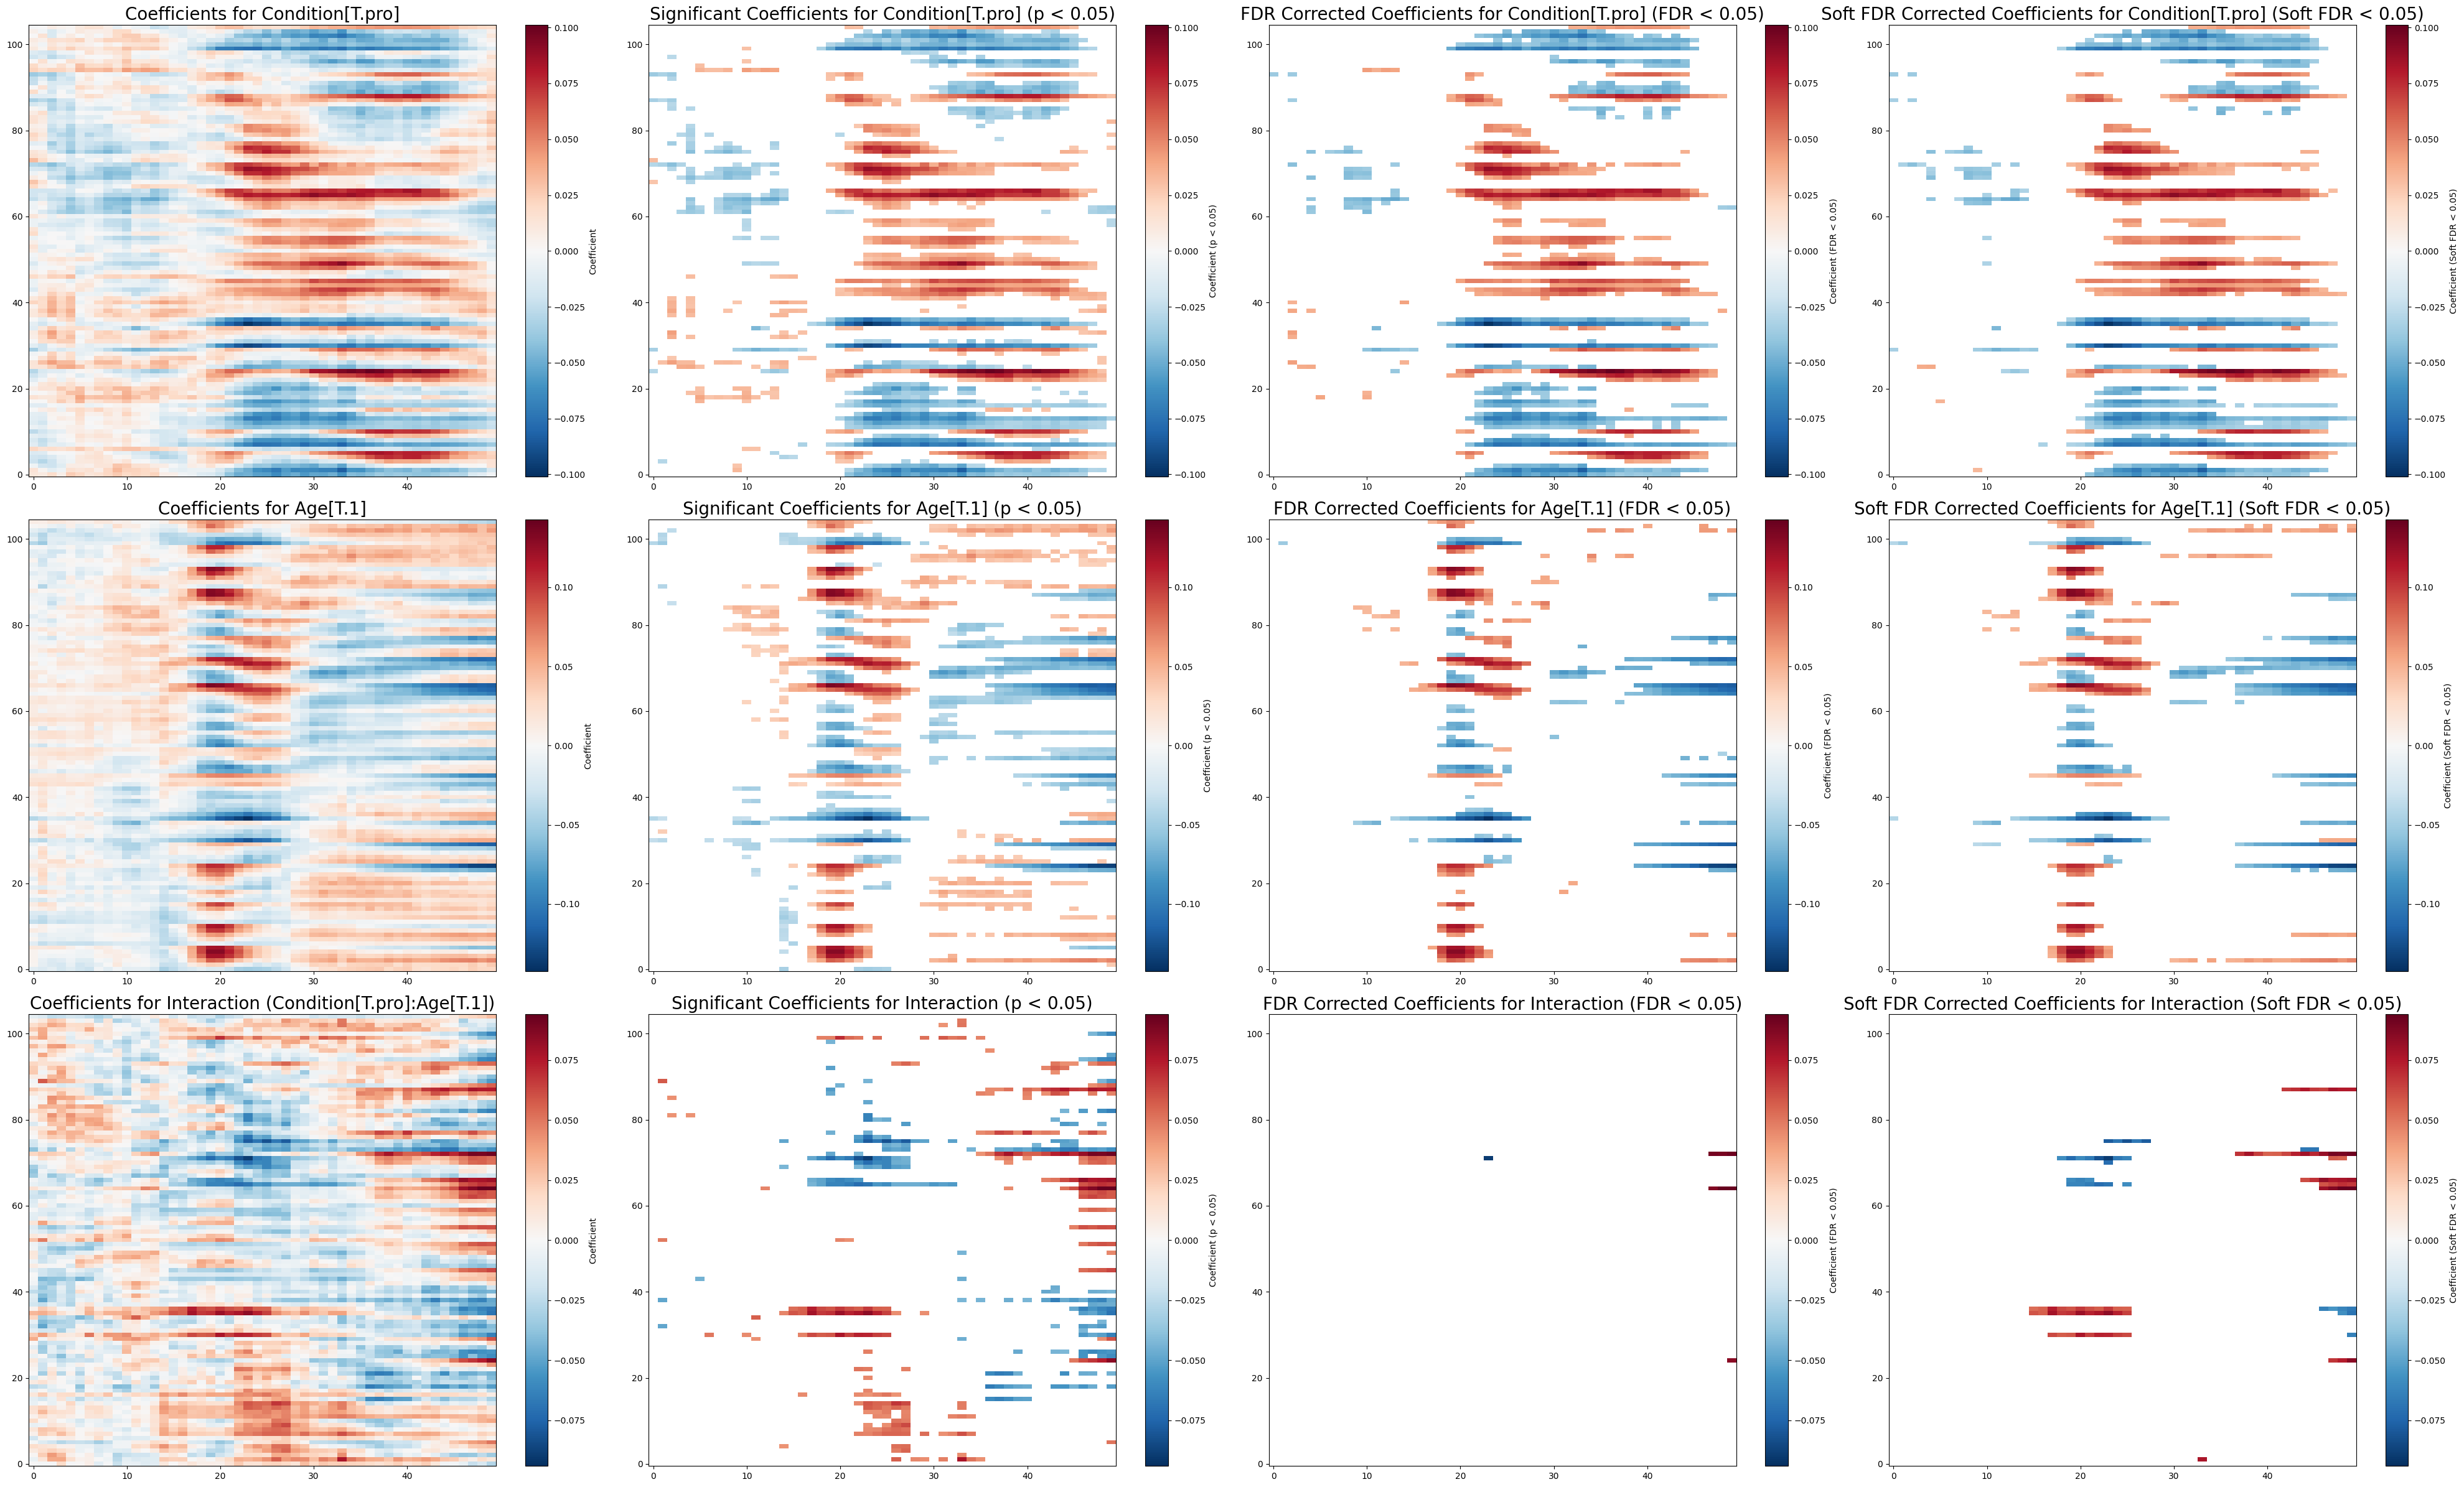

In [18]:


def plot_complex_coefficients(results):
    plt.figure(figsize=(40, 24))  # 3 rows and 4 columns of plots

    pvalues_cond = extract_pvalues(results, 'Condition[T.pro]')
    pvalues_age = extract_pvalues(results, 'Age[T.1]')
    pvalues_interaction = extract_pvalues(results, 'Condition[T.pro]:Age[T.1]')

    fdr_corrected_cond = fdr_correction(pvalues_cond)
    fdr_corrected_age = fdr_correction(pvalues_age)
    fdr_corrected_interaction = fdr_correction(pvalues_interaction)

    soft_fdr_corrected_cond = soft_fdr_correction(pvalues_cond)
    soft_fdr_corrected_age = soft_fdr_correction(pvalues_age)
    soft_fdr_corrected_interaction = soft_fdr_correction(pvalues_interaction)

    coefficients_cond = extract_coefficients(results, 'Condition[T.pro]')
    coefficients_age = extract_coefficients(results, 'Age[T.1]')
    coefficients_interaction = extract_coefficients(results, 'Condition[T.pro]:Age[T.1]')

    title_fontsize = 20 

    # Condition[T.pro]
    ax1 = plt.subplot(3, 4, 1)
    cax1 = ax1.imshow(coefficients_cond, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(coefficients_cond)), vmax=np.nanmax(np.abs(coefficients_cond)))
    plt.colorbar(cax1, ax=ax1, label='Coefficient')
    ax1.set_title('Coefficients for Condition[T.pro]', fontsize=title_fontsize)

    ax2 = plt.subplot(3, 4, 2)
    significant_cond = np.where(pvalues_cond < 0.05, coefficients_cond, np.nan)
    cax2 = ax2.imshow(significant_cond, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_cond)), vmax=np.nanmax(np.abs(significant_cond)))
    plt.colorbar(cax2, ax=ax2, label='Coefficient (p < 0.05)')
    ax2.set_title('Significant Coefficients for Condition[T.pro] (p < 0.05)', fontsize=title_fontsize)

    ax3 = plt.subplot(3, 4, 3)
    significant_fdr_cond = np.where(fdr_corrected_cond < 0.05, coefficients_cond, np.nan)
    cax3 = ax3.imshow(significant_fdr_cond, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_fdr_cond)), vmax=np.nanmax(np.abs(significant_fdr_cond)))
    plt.colorbar(cax3, ax=ax3, label='Coefficient (FDR < 0.05)')
    ax3.set_title('FDR Corrected Coefficients for Condition[T.pro] (FDR < 0.05)', fontsize=title_fontsize)

    ax4 = plt.subplot(3, 4, 4)
    significant_soft_fdr_cond = np.where(soft_fdr_corrected_cond < 0.05, coefficients_cond, np.nan)
    cax4 = ax4.imshow(significant_soft_fdr_cond, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_soft_fdr_cond)), vmax=np.nanmax(np.abs(significant_soft_fdr_cond)))
    plt.colorbar(cax4, ax=ax4, label='Coefficient (Soft FDR < 0.05)')
    ax4.set_title('Soft FDR Corrected Coefficients for Condition[T.pro] (Soft FDR < 0.05)', fontsize=title_fontsize)

    # Age[T.1]
    ax5 = plt.subplot(3, 4, 5)
    cax5 = ax5.imshow(coefficients_age, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(coefficients_age)), vmax=np.nanmax(np.abs(coefficients_age)))
    plt.colorbar(cax5, ax=ax5, label='Coefficient')
    ax5.set_title('Coefficients for Age[T.1]', fontsize=title_fontsize)

    ax6 = plt.subplot(3, 4, 6)
    significant_age = np.where(pvalues_age < 0.05, coefficients_age, np.nan)
    cax6 = ax6.imshow(significant_age, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_age)), vmax=np.nanmax(np.abs(significant_age)))
    plt.colorbar(cax6, ax=ax6, label='Coefficient (p < 0.05)')
    ax6.set_title('Significant Coefficients for Age[T.1] (p < 0.05)', fontsize=title_fontsize)

    ax7 = plt.subplot(3, 4, 7)
    significant_fdr_age = np.where(fdr_corrected_age < 0.05, coefficients_age, np.nan)
    cax7 = ax7.imshow(significant_fdr_age, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_fdr_age)), vmax=np.nanmax(np.abs(significant_fdr_age)))
    plt.colorbar(cax7, ax=ax7, label='Coefficient (FDR < 0.05)')
    ax7.set_title('FDR Corrected Coefficients for Age[T.1] (FDR < 0.05)', fontsize=title_fontsize)

    ax8 = plt.subplot(3, 4, 8)
    significant_soft_fdr_age = np.where(soft_fdr_corrected_age < 0.05, coefficients_age, np.nan)
    cax8 = ax8.imshow(significant_soft_fdr_age, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_soft_fdr_age)), vmax=np.nanmax(np.abs(significant_soft_fdr_age)))
    plt.colorbar(cax8, ax=ax8, label='Coefficient (Soft FDR < 0.05)')
    ax8.set_title('Soft FDR Corrected Coefficients for Age[T.1] (Soft FDR < 0.05)', fontsize=title_fontsize)

    # Interaction
    ax9 = plt.subplot(3, 4, 9)
    cax9 = ax9.imshow(coefficients_interaction, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(coefficients_interaction)), vmax=np.nanmax(np.abs(coefficients_interaction)))
    plt.colorbar(cax9, ax=ax9, label='Coefficient')
    ax9.set_title('Coefficients for Interaction (Condition[T.pro]:Age[T.1])', fontsize=title_fontsize)

    ax10 = plt.subplot(3, 4, 10)
    significant_interaction = np.where(pvalues_interaction < 0.05, coefficients_interaction, np.nan)
    cax10 = ax10.imshow(significant_interaction, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_interaction)), vmax=np.nanmax(np.abs(significant_interaction)))
    plt.colorbar(cax10, ax=ax10, label='Coefficient (p < 0.05)')
    ax10.set_title('Significant Coefficients for Interaction (p < 0.05)', fontsize=title_fontsize)

    ax11 = plt.subplot(3, 4, 11)
    significant_fdr_interaction = np.where(fdr_corrected_interaction < 0.05, coefficients_interaction, np.nan)
    cax11 = ax11.imshow(significant_fdr_interaction, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_fdr_interaction)), vmax=np.nanmax(np.abs(significant_fdr_interaction)))
    plt.colorbar(cax11, ax=ax11, label='Coefficient (FDR < 0.05)')
    ax11.set_title('FDR Corrected Coefficients for Interaction (FDR < 0.05)', fontsize=title_fontsize)

    ax12 = plt.subplot(3, 4, 12)
    significant_soft_fdr_interaction = np.where(soft_fdr_corrected_interaction < 0.05, coefficients_interaction, np.nan)
    cax12 = ax12.imshow(significant_soft_fdr_interaction, aspect='auto', interpolation='none', origin='lower', cmap='RdBu_r', vmin=-np.nanmax(np.abs(significant_soft_fdr_interaction)), vmax=np.nanmax(np.abs(significant_soft_fdr_interaction)))
    plt.colorbar(cax12, ax=ax12, label='Coefficient (Soft FDR < 0.05)')
    ax12.set_title('Soft FDR Corrected Coefficients for Interaction (Soft FDR < 0.05)', fontsize=title_fontsize)

    plt.tight_layout()  
    plt.show()

def extract_pvalues(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    pvalues = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            p_value = result.pvalues[term]
            pvalues[channel, timepoint] = p_value
        except (KeyError, AttributeError):
            print(f"Missing p-value for {term} (Channel {channel}, Timepoint {timepoint})")

    return pvalues

def extract_coefficients(results, term):
    max_channel = max(key[0] for key in results.keys()) + 1
    max_timepoint = max(key[1] for key in results.keys()) + 1
    coefficients = np.full((max_channel, max_timepoint), np.nan)  

    for (channel, timepoint), result in results.items():
        try:
            coefficient = result.params[term]
            coefficients[channel, timepoint] = coefficient
        except (KeyError, AttributeError):
            print(f"Missing coefficient for {term} (Channel {channel}, Timepoint {timepoint})")

    return coefficients

def fdr_correction(pvalues):
    pvalues_flat = pvalues.flatten()
    nan_mask = np.isnan(pvalues_flat)
    pvalues_nonan = pvalues_flat[~nan_mask]

    if pvalues_nonan.size == 0:
        return pvalues

    _, pvalues_corrected, _, _ = multipletests(pvalues_nonan, method='fdr_bh')
    pvalues_corrected_full = np.full_like(pvalues_flat, np.nan)
    pvalues_corrected_full[~nan_mask] = pvalues_corrected

    return pvalues_corrected_full.reshape(pvalues.shape)

def soft_fdr_correction(pvalues):
    corrected_pvalues = np.full_like(pvalues, np.nan)
    for i in range(pvalues.shape[0]):  # Loop over each electrode
        pvalues_row = pvalues[i, :]
        nan_mask = np.isnan(pvalues_row)
        pvalues_nonan = pvalues_row[~nan_mask]

        if pvalues_nonan.size > 0:
            _, pvalues_corrected, _, _ = multipletests(pvalues_nonan, method='fdr_bh')
            corrected_pvalues[i, ~nan_mask] = pvalues_corrected

    return corrected_pvalues

def load_results(filename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)

plot_complex_coefficients(results)
